# Designing a Machine Learning Pipeline for Preventive Maintenance of HVAC Systems

**APS490: Multidisciplinary Capstone Project**

Team Members: Elizabeth Chelmecki, Anoja Muthucumaru, Chi Zhang, Shirley Zhang, Sherry Zuo 

This colab notebook is a simplified demo of the ML pipeline for predicting the behaviour of air flow in VAV boxes. For complete code and UI, see https://github.com/chuiyunjun/aps490.

To run this notebook, either run each cell individually by clicking the play button at the top left corner, or go to Runtime -> Run all.

## Setting up

Before running the following code, go to Runtime -> Change runtime type -> set Hardware Accelerator as GPU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import csv
import torch.nn as nn
import torch
from tqdm.notebook import tqdm as tqdm
import random
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
random.seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make sure the following path matches where the folder is actually stored (i.e., place the APS490 folder in your main google drive folder)

In [3]:
%cd '/content/drive/MyDrive/APS490/colab_demo/'

/content/drive/MyDrive/APS490/colab_demo


In [4]:
data_root = 'prediction/datasets/all/'
weather_data_root = 'prediction/datasets/weather/'

## Data Preparation and Exploratory Analysis

### MNG Data

define inputs and outputs

In [5]:
datetime = 'DateTime'

input1 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint'
input2 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position'
input3 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature'
input4 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'
input5 = 'Temp (°C)'

#INPUT_LIST_V = [datetime, input1, input2, input3, input4, input5]
INPUT_LIST_A = [datetime, input1, input4, input3, input2, input5] #second input is our output

In [6]:
mng_list = []
for file in os.listdir(data_root):
    df = pd.read_csv(data_root + file)
    mng_list.append(df)
mng = pd.concat(mng_list, axis=0)
mng.sort_values(datetime)
mng = mng[INPUT_LIST_A[:-1]]
mng=mng.dropna()
mng

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,14,16,30,44,58,72,86,100,114,128,142,156,170,184,198,212,226,240,254,268,282,296,310,324,338,352,366,380,394,408,422,436,450,464,478,492,506,520,534,548,562,576,590,604) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DateTime,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position
106,2021/02/01 08:50:00.000,144.000000,145.229981,20.830345,75.393906
107,2021/02/01 08:55:00.000,144.000000,143.711624,20.837288,77.659592
108,2021/02/01 09:00:00.000,144.000000,144.028381,20.823696,78.571823
109,2021/02/01 09:05:00.000,144.000000,143.190216,20.799400,77.693443
110,2021/02/01 09:10:00.000,144.000000,144.421188,20.791056,76.556046
...,...,...,...,...,...
3392,2021/10/14 15:40:00.000,275.171631,270.433197,22.901604,100.000000
3393,2021/10/14 15:45:00.000,283.475281,273.153076,22.887646,100.000000
3394,2021/10/14 15:50:00.000,293.263733,283.200043,22.882143,100.000000
3395,2021/10/14 15:55:00.000,301.169067,293.846527,22.869499,100.000000


### weather data

In [7]:
weather_list = []
for file in os.listdir(weather_data_root):
    df = pd.read_csv(weather_data_root + file)
    weather_list.append(df)
weather = pd.concat(weather_list, axis=0)

weather = weather[['Date/Time (LST)', 'Temp (°C)']].dropna()
weather.rename(columns = {'Date/Time (LST)':'DateTime'}, inplace = True)
weather

,DateTime,Temp (°C)
0,2021-07-01 00:00,20.8
1,2021-07-01 01:00,20.2
2,2021-07-01 02:00,19.8
3,2021-07-01 03:00,20.3
4,2021-07-01 04:00,19.8
...,...,...
739,2021-08-31 19:00,21.7
740,2021-08-31 20:00,20.8
741,2021-08-31 21:00,20.1
742,2021-08-31 22:00,19.6


### join MNG data with weather data

In [8]:
weather['DateTime 2'] = pd.to_datetime(weather.DateTime)
mng['DateTime'] = pd.to_datetime(mng.DateTime)
mng['DateTime 2'] = mng['DateTime'].dt.floor('h')
df_input = pd.merge(mng, weather, how='left', on = 'DateTime 2').dropna()
df_input = df_input.drop(['DateTime 2','DateTime_y'], axis=1)
df_input

,DateTime_x,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position,Temp (°C)
0,2021-02-01 08:50:00,144.000000,145.229981,20.830345,75.393906,-8.2
1,2021-02-01 08:55:00,144.000000,143.711624,20.837288,77.659592,-8.2
2,2021-02-01 09:00:00,144.000000,144.028381,20.823696,78.571823,-8.0
3,2021-02-01 09:05:00,144.000000,143.190216,20.799400,77.693443,-8.0
4,2021-02-01 09:10:00,144.000000,144.421188,20.791056,76.556046,-8.0
...,...,...,...,...,...,...
73510,2021-10-14 15:40:00,275.171631,270.433197,22.901604,100.000000,21.2
73511,2021-10-14 15:45:00,283.475281,273.153076,22.887646,100.000000,21.2
73512,2021-10-14 15:50:00,293.263733,283.200043,22.882143,100.000000,21.2
73513,2021-10-14 15:55:00,301.169067,293.846527,22.869499,100.000000,21.2


add datetime features including week of year, hour of day, and weekday

In [9]:
df_input['DateTime_x'] = pd.to_datetime(df_input['DateTime_x'])
df_input.set_index('DateTime_x', drop=False, inplace=True)
df_input['week_of_year'] = [i.weekofyear for i in df_input.index]
df_input['hour'] = [i.hour for i in df_input.index]
df_input['is_weekday'] = [i.isoweekday() for i in df_input.index]
df_input = df_input.drop(['DateTime_x'], axis=1)
df_input

,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature,Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position,Temp (°C),week_of_year,hour,is_weekday
DateTime_x,,,,,,,,
2021-02-01 08:50:00,144.000000,145.229981,20.830345,75.393906,-8.2,5,8,1
2021-02-01 08:55:00,144.000000,143.711624,20.837288,77.659592,-8.2,5,8,1
2021-02-01 09:00:00,144.000000,144.028381,20.823696,78.571823,-8.0,5,9,1
2021-02-01 09:05:00,144.000000,143.190216,20.799400,77.693443,-8.0,5,9,1
2021-02-01 09:10:00,144.000000,144.421188,20.791056,76.556046,-8.0,5,9,1
...,...,...,...,...,...,...,...,...
2021-10-14 15:40:00,275.171631,270.433197,22.901604,100.000000,21.2,41,15,4
2021-10-14 15:45:00,283.475281,273.153076,22.887646,100.000000,21.2,41,15,4
2021-10-14 15:50:00,293.263733,283.200043,22.882143,100.000000,21.2,41,15,4


### Exploratory data analysis

zone temperature vs outdoor temperature

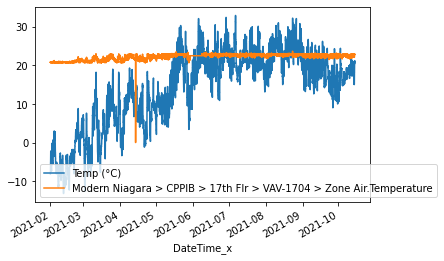

In [10]:
df_input.plot(y=['Temp (°C)','Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature'])

valve position vs air flow

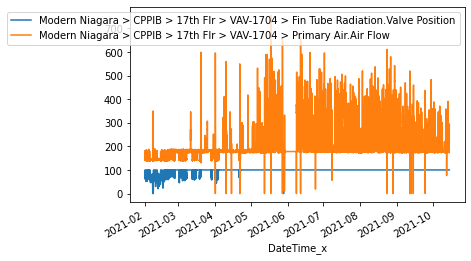

In [11]:
df_input.plot(y=['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position','Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'])

airflow vs airflow setpoint

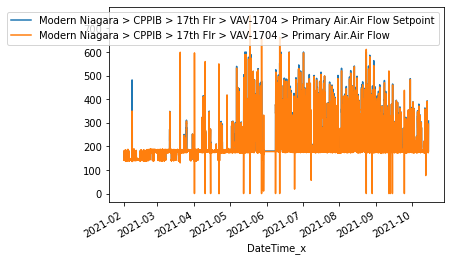

In [12]:
df_input.plot(y=['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint','Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'])

datetime features

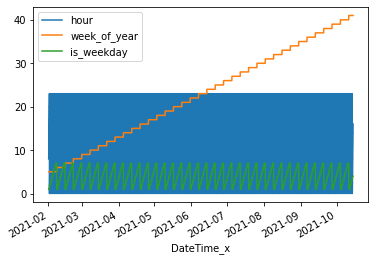

In [13]:
df_input.plot(y=['hour','week_of_year','is_weekday'])

## ML Prediction

### ML Model Setup

In [14]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import csv 
import shutil
from numpy.lib.index_tricks import diag_indices_from

In [15]:
def sliding_windows(data, seq_length, pred_length, sc):
    x = []
    y = []
    samples = []
    for i in range(len(data)-seq_length-pred_length):
        sample = data[i:(i+seq_length+pred_length)]
        samples.append(sample)
    random.shuffle(samples)
    x = np.array(samples)[:,:seq_length,:]
    y = np.array(samples)[:,seq_length:,:]
    y = y[:,:,1]
    return x, y

def train_test_split(x, y, param):
  train_size = param['train_size']
  validation_size = param['validation_size']
  test_size = param['test_size']


  dataX = torch.Tensor(np.array(x)).to('cuda')
  dataY = torch.Tensor(np.array(y)).to('cuda')

  trainX = torch.Tensor(np.array(x[0:train_size])).to('cuda')
  trainY = torch.Tensor(np.array(y[0:train_size])).to('cuda')

  validationX = torch.Tensor(np.array(x[train_size: train_size+validation_size])).to('cuda')
  validationY = torch.Tensor(np.array(y[train_size: train_size+validation_size])).to('cuda')

  # testY doesn't contain 0
  testX = []
  testY = []
  index = train_size+validation_size
  i = 0
  val_count = 0
  inval_count = 0
  while i < train_size and index < len(y):
    if np.all(y[index]):
      testX.append(x[index])
      testY.append(y[index])
      i += 1
      val_count += 1
    else:
      inval_count += 1
    index += 1
  print('val:', val_count, 'inval_count', inval_count)
  testX = torch.Tensor(np.array(testX)).to('cuda')
  testY = torch.Tensor(np.array(testY)).to('cuda')
  # testX = torch.Tensor(np.array(x[train_size+validation_size:train_size+validation_size+train_size])).to('cuda')
  # testY = torch.Tensor(np.array(y[train_size+validation_size:train_size+validation_size+train_size])).to('cuda')
  return dataX, dataY, trainX, trainY, validationX, validationY, testX, testY

def batch_split(x, y, param):
  l = len(x)
  if 'batch_size' in param:
    batch_size = param['batch_size']
    batch_num = l // param['batch_size'] if l // param['batch_size'] == 0 else l // param['batch_size'] + 1
  elif 'batch_num' in param:
    batch_num = param['batch_num']
    batch_size = l // param['batch_num'] if l // param['batch_num'] == 0 else l // param['batch_num'] + 1
  
  x_list, y_list = [], []
  for i in range(batch_num):
    if (i+1) * batch_size > l:
      x_list.append(x[i * batch_size: ])
      y_list.append(y[i * batch_size: ])
    else: 
      x_list.append(x[i * batch_size: (i+1) * batch_size])
      y_list.append(y[i * batch_size: (i+1) * batch_size])
  return x_list, y_list, batch_num

def train_and_evaluate(param, validationX, validationY, trainX, trainY, model):
  train_loss_list = torch.tensor([]).to('cuda')
  validation_loss_list = torch.tensor([]).to('cuda')
  
  trainX, trainY, num_batches = batch_split(trainX, trainY, param)
  validationX, validationY, num_batches = batch_split(validationX, validationY, param)

  optimizer = param["optimizer"]
  if param['criterion'] == 'mse':
    criterion = torch.nn.MSELoss()
  elif param['criterion'] == 'mae':
    criterion = torch.nn.L1Loss()
  elif param['criterion'].startswith('huber'):
    delta = float(param['criterion'].split('_')[1])
    criterion = torch.nn.HuberLoss(delta=delta)
  elif param['criterion'] == 'nll':
    criterion = torch.nn.NLLLoss()
  else:
    print('Invalid criterion name: {}'.format(param['criterion']))

  # Train the model
  for epoch in tqdm(range(param['num_epochs'])):
      curr_batch_train_loss_list = torch.tensor([]).to('cuda')
      curr_batch_validation_loss_list = torch.tensor([]).to('cuda')
      for b in range(num_batches):
        outputs = model(trainX[b])
        optimizer.zero_grad()

        # obtain the loss function
        train_loss = criterion(outputs, trainY[b])

        curr_batch_train_loss_list = torch.cat((curr_batch_train_loss_list ,torch.tensor([train_loss.item()]).to('cuda')))

        train_loss.backward()
        
        optimizer.step()

        with torch.no_grad():
          pred_validationY = model(validationX[b])
          validation_loss = criterion(pred_validationY, validationY[b])
          curr_batch_validation_loss_list = torch.cat((curr_batch_validation_loss_list ,torch.tensor([validation_loss.item()]).to('cuda')))

      train_loss_list = torch.cat((train_loss_list ,torch.tensor([curr_batch_train_loss_list.mean().item()]).to('cuda')))
      validation_loss_list = torch.cat((validation_loss_list ,torch.tensor([curr_batch_validation_loss_list.mean().item()]).to('cuda')))

      if (epoch + 1) % 50 == 0:
        print("Epoch: %d, train_loss: %1.5f, val_loss: %1.5f" % (epoch, curr_batch_train_loss_list.mean().item(), curr_batch_validation_loss_list.mean().item()))
  return model, train_loss_list, validation_loss_list

def execute_and_save(param, model_name,  trainX, trainY, validationX, validationY, testX, testY):


  if param['criterion'] == 'mse':
    criterion = torch.nn.MSELoss()
  elif param['criterion'] == 'mae':
    criterion = torch.nn.L1Loss()
  elif param['criterion'].startswith('huber'):
    delta = float(param['criterion'].split('_')[1])
    criterion = torch.nn.HuberLoss(delta=delta)
  elif param['criterion'] == 'nll':
    criterion = torch.nn.NLLLoss()
  else:
    print('Invalid criterion name: {}'.format(param['criterion']))

  if model_name == 'lstm':
    model = LSTM(param['num_classes'], param['input_size'], param['hidden_size'], param['num_layers'])
  elif model_name == 'gru':
    model = GRUNet(param['num_classes'], param['input_size'], param['hidden_size'], param['num_layers'])
  else:
    print('Invalid model name. Please double-check.')
    return
  
  model.to('cuda')
  optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'])
  param["optimizer"] = optimizer


  model, train_loss, validation_loss = train_and_evaluate(param, validationX, validationY, trainX, trainY, model)


  with torch.no_grad():
    test_predict = model(testX)

  test_data_predict = test_predict.data.cpu().numpy()
  test_data_true = torch.squeeze(testY).data.data.cpu().numpy()

  min = sc.data_min_[1]
  max = sc.data_max_[1]

  test_data_predict_np = test_data_predict * (max - min) + min
  test_data_predict_df = pd.DataFrame(test_data_predict_np)
  test_data_true_np = test_data_true * (max - min) + min
  test_data_true_df = pd.DataFrame(test_data_true_np)

  test_mae_loss = mean_absolute_error(test_data_true_np, test_data_predict_np)
  test_mape_loss = mean_absolute_percentage_error(test_data_true_np, test_data_predict_np)

  return test_data_predict_df, test_data_true_df, test_data_predict_np, test_data_true_np, validation_loss[-1].item(), test_mae_loss, test_mape_loss, model

### LSTM Model

define LSTM model architecture

In [16]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes).to('cuda')

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size).to('cuda')
        
        out = self.fc(h_out)
        return out

train LSTM model

In [17]:
param_lstm = {
    'num_epochs':1200,
    'batch_num':1,
    'learning_rate': 0.008,
    'dropout': 0,
    'input_size': 8, # number of input variables
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # should be same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 55000,
    'validation_size': 5000,
    'test_size': 10000,
}

sc = MinMaxScaler()
training_data = sc.fit_transform(df_input)
x, y = sliding_windows(training_data, param_lstm['seq_length'], param_lstm['pred_length'], sc)
dataX, dataY, trainX, trainY, validationX, validationY, testX, testY = train_test_split(x, y, param_lstm)

fields = ['index'] + list(param_lstm.keys()) + [ 'optimizer', 'validation loss', 'test_mae_loss', 'test_mape_loss']

results_path = '/content/drive/MyDrive/APS490/colab_demo/output/airflow_results_lstm/'
if not os.path.exists(results_path):
  os.mkdir(results_path)
os.chdir(results_path)
for f in os.listdir():
  if os.path.isdir(f):
    shutil.rmtree(f)
  else:
    os.remove(f)


results = []
for criteria in ['huber_0.015']:
  os.chdir(results_path)
  min_loss, index = -1, -1
  predict_df, true_df, model_to_save = None, None, None
  rows = []
  param_lstm['criterion'] = criteria

  count = 0
  for sq in [48]:
    param_lstm['seq_length'] = sq
    for hidden_size in [4]:
      param_lstm['hidden_size'] = hidden_size
      
      test_predict_df, test_true_df, test_predict_np, test_true_np, validation_loss, test_mae_loss, test_mape_loss, model = execute_and_save(param_lstm, 'lstm', trainX, trainY, validationX, validationY, testX, testY)
      print('val_loss:', validation_loss)
      print('mae:', test_mae_loss)
      print('mape:', test_mape_loss)
      row = list(param_lstm.values())
      rows.append([count] + row + [validation_loss, test_mae_loss, test_mape_loss])
      if min_loss < 0 or min_loss > validation_loss:
        min_loss = validation_loss
        index = count
        predict_df, true_df, model_to_save = test_predict_df, test_true_df, model
      count += 1


  filename = "{}_results_report.csv".format(criteria)
  # writing to csv file 
  with open(filename, 'w') as csvfile: 
      csvwriter = csv.writer(csvfile) 
      csvwriter.writerow(fields) 
      csvwriter.writerows(rows)
  os.mkdir(results_path+"{}_optimized_model".format(criteria))
  os.chdir(results_path+"{}_optimized_model".format(criteria))
  predict_df.to_csv('prediction_tesetY_results_{}(index:{}).csv'.format(criteria, index))
  true_df.to_csv('true_testY_results_{}(index:{}).csv'.format(criteria, index))
  torch.save(model_to_save, 'model_{}(index:{}).pth'.format(criteria, index))
  results.append(rows[index])

os.chdir(results_path)
filename = "report.csv"
with open(filename, 'w') as f: 
  csvwriter = csv.writer(f) 
  csvwriter.writerow(fields) 
  csvwriter.writerows(results)

val: 13296 inval_count 87


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00072, val_loss: 0.00069
Epoch: 99, train_loss: 0.00050, val_loss: 0.00048
Epoch: 149, train_loss: 0.00032, val_loss: 0.00031
Epoch: 199, train_loss: 0.00030, val_loss: 0.00030
Epoch: 249, train_loss: 0.00030, val_loss: 0.00029
Epoch: 299, train_loss: 0.00030, val_loss: 0.00029
Epoch: 349, train_loss: 0.00030, val_loss: 0.00029
Epoch: 399, train_loss: 0.00030, val_loss: 0.00029
Epoch: 449, train_loss: 0.00029, val_loss: 0.00029
Epoch: 499, train_loss: 0.00029, val_loss: 0.00029
Epoch: 549, train_loss: 0.00029, val_loss: 0.00029
Epoch: 599, train_loss: 0.00029, val_loss: 0.00029
Epoch: 649, train_loss: 0.00029, val_loss: 0.00029
Epoch: 699, train_loss: 0.00029, val_loss: 0.00029
Epoch: 749, train_loss: 0.00029, val_loss: 0.00028
Epoch: 799, train_loss: 0.00029, val_loss: 0.00028
Epoch: 849, train_loss: 0.00029, val_loss: 0.00028
Epoch: 899, train_loss: 0.00029, val_loss: 0.00028
Epoch: 949, train_loss: 0.00029, val_loss: 0.00028
Epoch: 999, train_loss: 0.00028, 

change sample_index_lstm to view prediction results at different times

In [18]:
data=df_input
data = pd.DataFrame(data, columns=df_input.columns)
train = data.iloc[:-10000,:]
test = data.iloc[-10000:,:]

sample_index_lstm = 200

sc = MinMaxScaler()
sc = sc.fit(df_input)
sampleX = sc.transform(test[sample_index_lstm-48:sample_index_lstm]).reshape(1,48, 8)
sampleX = torch.tensor(sampleX).to('cuda')
sampleX = sampleX.float()
lstm_model = torch.load('/content/drive/MyDrive/APS490/colab_demo/output/airflow_results_lstm/huber_0.015_optimized_model/model_huber_0.015(index:0).pth')
lstm_model.eval()
lstm_model.to('cuda')

pred = lstm_model(sampleX)
min = sc.data_min_[1]
max = sc.data_max_[1]

pred_lstm = pred * (max - min) + min
pred_lstm = pred_lstm.cpu()
pred_lstm = pred_lstm.detach().numpy()

view prediction results


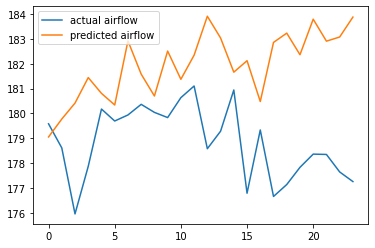

In [19]:
ac_airflow = test[sample_index_lstm:sample_index_lstm+24]['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'].values.tolist()
plt.plot(ac_airflow, label = 'actual airflow')
plt.plot(pred_lstm[0], label = 'predicted airflow')
plt.legend()
plt.show()

### GRU Model

Define GRU model architecture

In [20]:
class GRUNet(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        h_out, _ = self.gru(x, h_0)
        
        h_out = h_out[:, -1, :].to('cuda')
        
        out = self.fc(h_out).to('cuda')
        
        return out

train GRU model

In [21]:
param_gru = {
    'num_epochs':1000,
    'batch_num': 1,
    'learning_rate': 0.008,
    'input_size': 8,
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # dummy variable, same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 55000,
    'test_size': 5000,
    'validation_size': 10000,
    'criterion': 'mae'
}

sc = MinMaxScaler()
training_data = sc.fit_transform(df_input)
x, y = sliding_windows(training_data, param_gru['seq_length'], param_gru['pred_length'], sc)
dataX, dataY, trainX, trainY, validationX, validationY, testX, testY = train_test_split(x, y, param_gru)

fields = ['index'] + list(param_gru.keys()) + ['criterion', 'optimizer', 'validation loss', 'test_mae_loss', 'test_mape_loss']

results_path = r'/content/drive/MyDrive/APS490/colab_demo/output/airflow_results_gru/'
if not os.path.exists(results_path):
  os.mkdir(results_path)
os.chdir(results_path)
for f in os.listdir():
  if os.path.isdir(f):
    shutil.rmtree(f)
  else:
    os.remove(f)


results = []
for criteria in ['huber_0.022']:
  os.chdir(results_path)
  min_loss, index = -1, -1
  predict_df, true_df, model_to_save = None, None, None
  rows = []
  param_gru['criterion'] = criteria

  count = 0
  for sq in [48]:
    param_gru['seq_length'] = sq
    for hidden_size in [4]:
      param_gru['hidden_size'] = hidden_size
      
      test_predict_df, test_true_df, test_predict_np, test_true_np, validation_loss, test_mae_loss, test_mape_loss, model = execute_and_save(param_gru, 'gru', trainX, trainY, validationX, validationY, testX, testY)
      print('val_loss:', validation_loss)
      print('mae:', test_mae_loss)
      print('mape:', test_mape_loss)
      row = list(param_gru.values())
      rows.append([count] + row + [validation_loss, test_mae_loss, test_mape_loss])
      if min_loss < 0 or min_loss > validation_loss:
        min_loss = validation_loss
        index = count
        predict_df, true_df, model_to_save = test_predict_df, test_true_df, model
      count += 1


  filename = "{}_results_report.csv".format(criteria)
  # writing to csv file 
  with open(filename, 'w') as csvfile: 
      csvwriter = csv.writer(csvfile) 
      csvwriter.writerow(fields) 
      csvwriter.writerows(rows)
  os.mkdir(results_path+"{}_optimized_model".format(criteria))
  os.chdir(results_path+"{}_optimized_model".format(criteria))
  predict_df.to_csv('prediction_tesetY_results_{}(index:{}).csv'.format(criteria, index))
  true_df.to_csv('true_testY_results_{}(index:{}).csv'.format(criteria, index))
  torch.save(model_to_save, 'model_{}(index:{}).pth'.format(criteria, index))
  results.append(rows[index])

os.chdir(results_path)
filename = "report.csv"
with open(filename, 'w') as f: 
  csvwriter = csv.writer(f) 
  csvwriter.writerow(fields) 
  csvwriter.writerows(results)



val: 8327 inval_count 56


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00126, val_loss: 0.00122
Epoch: 99, train_loss: 0.00061, val_loss: 0.00062
Epoch: 149, train_loss: 0.00051, val_loss: 0.00050
Epoch: 199, train_loss: 0.00044, val_loss: 0.00044
Epoch: 249, train_loss: 0.00042, val_loss: 0.00042
Epoch: 299, train_loss: 0.00041, val_loss: 0.00042
Epoch: 349, train_loss: 0.00041, val_loss: 0.00042
Epoch: 399, train_loss: 0.00041, val_loss: 0.00041
Epoch: 449, train_loss: 0.00041, val_loss: 0.00041
Epoch: 499, train_loss: 0.00041, val_loss: 0.00041
Epoch: 549, train_loss: 0.00041, val_loss: 0.00042
Epoch: 599, train_loss: 0.00040, val_loss: 0.00041
Epoch: 649, train_loss: 0.00040, val_loss: 0.00041
Epoch: 699, train_loss: 0.00040, val_loss: 0.00041
Epoch: 749, train_loss: 0.00040, val_loss: 0.00040
Epoch: 799, train_loss: 0.00040, val_loss: 0.00040
Epoch: 849, train_loss: 0.00040, val_loss: 0.00040
Epoch: 899, train_loss: 0.00040, val_loss: 0.00040
Epoch: 949, train_loss: 0.00040, val_loss: 0.00040
Epoch: 999, train_loss: 0.00039, 

change sample_index_gru to view prediction results at different times

In [22]:
data=df_input
data = pd.DataFrame(data, columns=df_input.columns)
train = data.iloc[:-10000,:]
test = data.iloc[-10000:,:]

sample_index_gru = 200

sc = MinMaxScaler()
sc = sc.fit(df_input)
sampleX = sc.transform(test[sample_index_gru-48:sample_index_gru]).reshape(1,48, 8)
sampleX = torch.tensor(sampleX).to('cuda')
sampleX = sampleX.float()
gru_model = torch.load('/content/drive/MyDrive/APS490/colab_demo/output/airflow_results_gru/huber_0.022_optimized_model/model_huber_0.022(index:0).pth')
gru_model.eval()
gru_model.to('cuda')

pred_gru = gru_model(sampleX)
min = sc.data_min_[1]
max = sc.data_max_[1]

pred_gru = pred_gru * (max - min) + min
pred_gru = pred_gru.cpu()
pred_gru = pred_gru.detach().numpy()

view prediction results

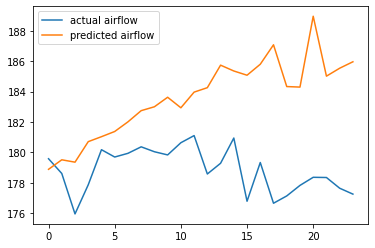

In [23]:
ac_airflow = test[sample_index_lstm:sample_index_lstm+24]['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'].values.tolist()
plt.plot(ac_airflow, label = 'actual airflow')
plt.plot(pred_gru[0], label = 'predicted airflow')
plt.legend()
plt.show()

### Baseline Model

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
def format_names(name):
  temp = name.split(' > ')[-1]
  temp = temp.replace('.', ' ')
  return temp
df_input.columns = [format_names(col) for col in df_input.columns]
for col in df_input.columns:
  adf_test(df_input[col])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Augmented Dickey-Fuller Test: 
ADF test statistic        -19.253471
p-value                     0.000000
# lags used                62.000000
# observations          73392.000000
critical value (1%)        -3.430439
critical value (5%)        -2.861579
critical value (10%)       -2.566791
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic        -19.373970
p-value                     0.000000
# lags used                60.000000
# observations          73394.000000
critical value (1%)        -3.430439
critical value (5%)        -2.861579
critical value (10%)       -2.566791
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -9.778855e+00
p-value                 6.818413e-17
# lags used             4.700000e+01
# observations          7.340700e+04
critical value (1%)

In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_input)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Primary Air Air Flow Setpoint ::  9537.94   > 143.6691  =>   True
Primary Air Air Flow ::  3243.69   > 111.7797  =>   True
Zone Air Temperature ::  1725.02   > 83.9383   =>   True
Fin Tube Radiation Valve Position ::  664.34    > 60.0627   =>   True
Temp (°C) ::  160.43    > 40.1749   =>   True
week_of_year ::  55.36     > 24.2761   =>   True
hour   ::  3.94      > 12.3212   =>   False
is_weekday ::  0.0       > 4.1296    =>   False


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


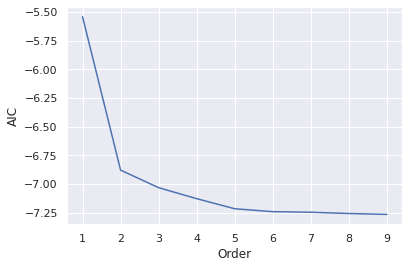

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Apr, 2022
Time:                     17:31:06
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -7.18364
Nobs:                     63449.0    HQIC:                  -7.22226
Log likelihood:          -490177.    FPE:                0.000717599
AIC:                     -7.23960    Det(Omega_mle):     0.000713181
--------------------------------------------------------------------
Results for equation Primary Air Air Flow Setpoint
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                       -3.253831         1.989805           -1.635           0.102
L1.Primary Air Air Flow Setpoint             1.1

In [26]:
sc = MinMaxScaler()
# data = sc.fit_transform(df_input)
data=df_input
data = pd.DataFrame(data, columns=df_input.columns)
train = data.iloc[:-10000,:]
test = data.iloc[-10000:,:]
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

results = forecasting_model.fit(6)
results.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


TEST MAE OF BASELINE:  17.134436346404613
TEST MAPE OF BASELINE (Percent):  7.320070560256021


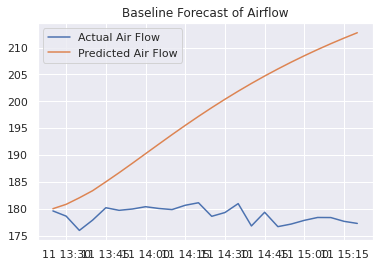

In [27]:
sample_index = 200
lagged_values = test[:sample_index].values[-6:]
next = results.forecast(y= lagged_values, steps=24)
next = pd.DataFrame(next, columns=df_input.columns)
actual_air_flow = test[sample_index:sample_index+24]['Primary Air Air Flow']
predicted_baseline = next['Primary Air Air Flow']
predicted_baseline.index = actual_air_flow.index
plt.plot(actual_air_flow, label='Actual Air Flow')
plt.plot(predicted_baseline, label='Predicted Air Flow')
plt.legend()
plt.title('Baseline Forecast of Airflow')
final = pd.DataFrame()
final['Actual airflow'] = actual_air_flow 
final['Predicted airflow'] = predicted_baseline 
path = r'/content/drive/MyDrive/APS490/colab_demo/output/baseline_results_airflow.csv'
final.to_csv(path)


mae_list = []
mape_list = []
for i in np.arange(start=6,step=24,stop=len(test)-24):
  lagged_values = test[:i].values[-6:]
  next = (results.forecast(y= lagged_values, steps=24))
  next = pd.DataFrame(next, columns=df_input.columns)
  actual = test[i:i+24]['Primary Air Air Flow']
  forecasted = np.array(next['Primary Air Air Flow'])
  actual = np.array(actual)
  mae = np.mean(np.abs(forecasted - actual))
  mape = np.mean(np.abs((forecasted- actual) / actual))
  mae_list.append(mae)
  if mape< 10:
    mape_list.append(mape)
print('TEST MAE OF BASELINE: ', np.mean(mae_list))
print('TEST MAPE OF BASELINE (Percent): ', np.mean(mape_list)*100)

## Final results comparison

Text(0.5, 1.0, 'Forecast of Airflow in the next 2 hours')

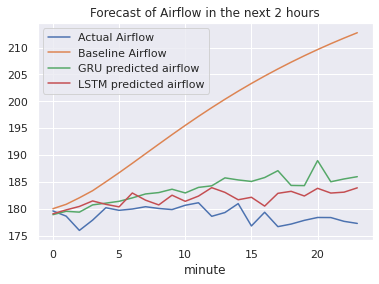

In [28]:
t = np.arange(24)
plt.plot(t,np.array(actual_air_flow), label='Actual Airflow')
plt.plot(t, np.array(predicted_baseline), label='Baseline Airflow')
plt.plot(t, pred_gru[0], label = 'GRU predicted airflow')
plt.plot(t, pred_lstm[0], label = 'LSTM predicted airflow')
plt.xlabel('minute')
plt.legend()
plt.title('Forecast of Airflow in the next 2 hours')